In [1]:
# Install required libraries
!pip install librosa

In [2]:
# Define paths to data
mp3_path = '/kaggle/input/PittCombined8class/mp3'

In [3]:
# Import necessary libraries
import os
import librosa
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

2024-08-22 00:47:49.952156: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 00:47:49.952313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 00:47:50.131573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# List files in directories
mp3_files = [os.path.join(mp3_path, file) for file in os.listdir(mp3_path) if file.endswith('.mp3')]
print(f"Found {len(mp3_files)} MP3 files.")

Found 1252 MP3 files.


In [8]:

import os
import re
import random
from collections import defaultdict, Counter
# Function to extract diagnosis from the corresponding cha file
def extract_diagnosis(mp3_file):
    cha_file = mp3_file.replace('.mp3', '.cha').replace('mp3', 'cha')
    try:
        with open(cha_file, 'r') as file:
            content = file.read()
        match = re.search(r'@ID:\s*[^|]*\|[^|]*\|[^|]*\|[^|]*\|[^|]*\|([^|]*)\|', content)
        return match.group(1).strip() if match else None
    except FileNotFoundError:
        return None

In [9]:
# Load all MP3 files and their diagnoses
diagnoses = [extract_diagnosis(f) for f in mp3_files]

In [10]:
# Group files by diagnosis
files_by_diagnosis = defaultdict(list)
for mp3_file, diag in zip(mp3_files, diagnoses):
    if diag:  # Ensure diagnosis exists
        files_by_diagnosis[diag].append(mp3_file)

In [11]:
# Select up to 500 files, trying to balance across diagnoses
selected_files = []
for diag, files in files_by_diagnosis.items():
    if len(files) >= 10:
        selected_files.extend(random.sample(files, min(len(files), max(500 // len(files_by_diagnosis), 10))))
selected_files = random.sample(selected_files, min(500, len(selected_files)))


In [12]:
# Extract features from audio
def preprocess_audio(mp3_file_path):
    y, sr = librosa.load(mp3_file_path, sr=22050)  # Use a consistent sampling rate
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs.mean(axis=1)

In [13]:
audio_features = [preprocess_audio(f) for f in selected_files]


In [14]:
# Encode labels
labels = [extract_diagnosis(f) for f in selected_files]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [15]:
# Prepare dataset
X = np.array(audio_features)
y = to_categorical(encoded_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Build model
input_layer = Input(shape=(13,))
x = Dense(64, activation='relu')(input_layer)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(len(np.unique(encoded_labels)), activation='softmax')(x)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
# Train and evaluate model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3342 - loss: 1.3896 - val_accuracy: 0.3778 - val_loss: 1.6406
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4010 - loss: 1.4068 - val_accuracy: 0.3778 - val_loss: 1.6433
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3959 - loss: 1.3885 - val_accuracy: 0.3556 - val_loss: 1.6530
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4272 - loss: 1.3579 - val_accuracy: 0.3778 - val_loss: 1.6414
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3388 - loss: 1.3945 - val_accuracy: 0.4000 - val_loss: 1.6318
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4639 - loss: 1.3394 - val_accuracy: 0.4000 - val_loss: 1.6231
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4362 - loss: 1.4065 - val_accuracy: 0.3778 - val_loss: 1.6327
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4188 - loss: 1.3484 - val_accuracy: 0.3556 - val_loss: 1.6332

In [26]:
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {evaluation[1]*100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2619 - loss: 1.7299 
Test Accuracy: 26.79%


In [27]:
from sklearn.metrics import classification_report

# Ensure the label encoder has been fitted
label_encoder.fit(labels)  # Make sure this is called somewhere in your code where 'labels' is your list of labels

# Predict classes on the test set
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_, output_dict=True)

# Print the classification report for each class
for label, metrics in report.items():
    if label in label_encoder.classes_:
        print(f"Class: {label}")
        print(f" Precision: {metrics['precision']:.2f}")
        print(f" Recall: {metrics['recall']:.2f}")
        print(f" F1-score: {metrics['f1-score']:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Class: Control
 Precision: 0.29
 Recall: 0.29
 F1-score: 0.29
Class: MCI
 Precision: 0.23
 Recall: 0.20
 F1-score: 0.21
Class: Memory
 Precision: 0.00
 Recall: 0.00
 F1-score: 0.00
Class: PossibleAD
 Precision: 0.75
 Recall: 0.25
 F1-score: 0.38
Class: ProbableAD
 Precision: 0.19
 Recall: 0.33
 F1-score: 0.24
Class: Vascular
 Precision: 0.22
 Recall: 0.40
 F1-score: 0.29


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
history.history

{'accuracy': [0.16292135417461395,
  0.23595505952835083,
  0.19662921130657196,
  0.2247191071510315,
  0.24719101190567017,
  0.18539325892925262,
  0.28651684522628784,
  0.21348313987255096,
  0.3089887499809265,
  0.26404494047164917,
  0.2921348214149475,
  0.2584269642829895,
  0.3314606845378876,
  0.31460675597190857,
  0.26404494047164917,
  0.31460675597190857,
  0.2921348214149475,
  0.31460675597190857,
  0.35393258929252625,
  0.33707866072654724,
  0.32022473216056824,
  0.3089887499809265,
  0.30337077379226685,
  0.3314606845378876,
  0.3764044940471649,
  0.32022473216056824,
  0.40449437499046326,
  0.4101123511791229,
  0.3089887499809265,
  0.3988763988018036,
  0.3595505654811859,
  0.3651685416698456,
  0.3258427083492279,
  0.3820224702358246,
  0.3932584226131439,
  0.38764044642448425,
  0.3988763988018036,
  0.3932584226131439,
  0.4101123511791229,
  0.3988763988018036,
  0.4438202381134033,
  0.3988763988018036,
  0.3651685416698456,
  0.38764044642448425,


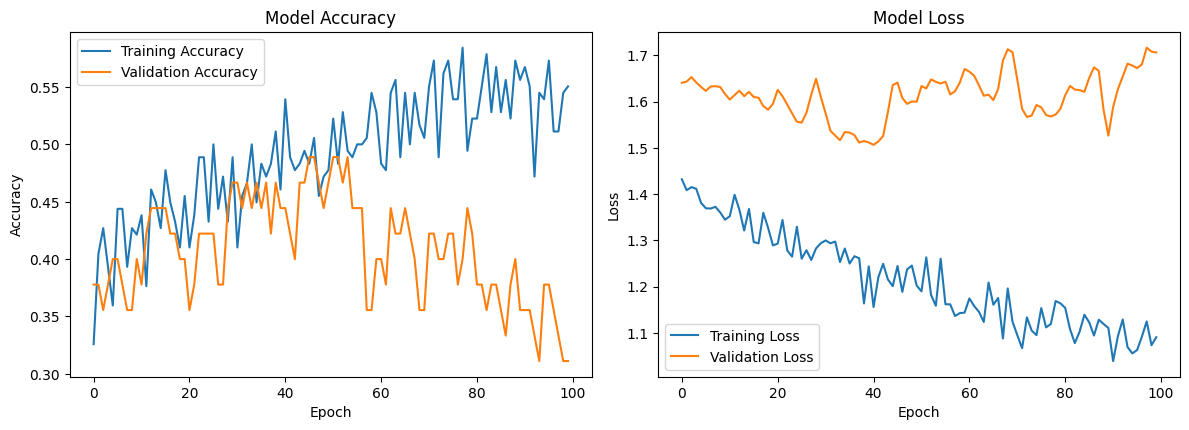

In [28]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable that stores the history returned by the model.fit() method
def plot_training_history(history):
    # Plotting accuracy
    plt.figure(figsize=(12, 8))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have trained the model with:
# history = model.fit(...)
# Call the function to plot
plot_training_history(history)


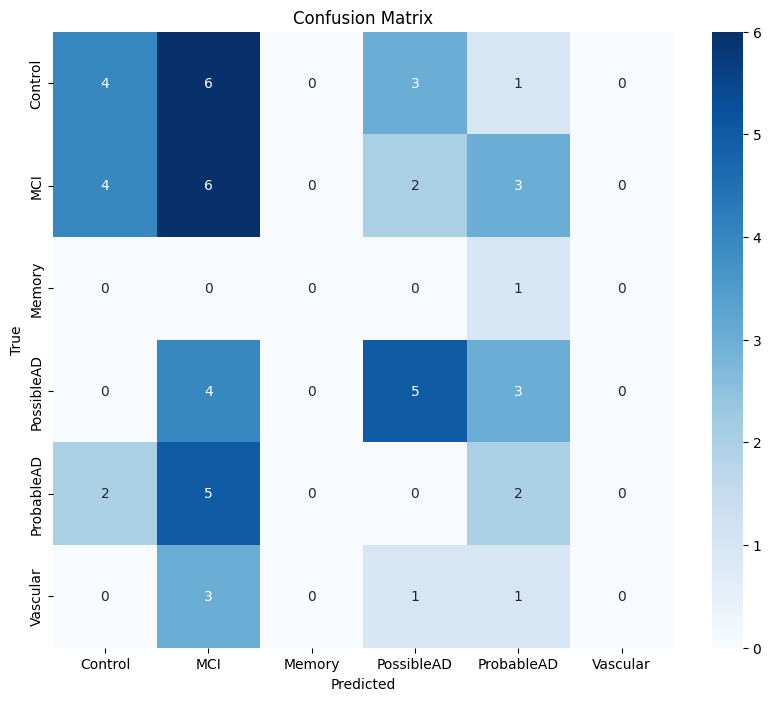

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'y_test' are the true labels and 'predicted_classes' are the predicted labels
def plot_confusion_matrix(y_test, predicted_classes, class_names):
    cm = confusion_matrix(y_test, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage:
class_names = label_encoder.classes_  # Assuming you have a label encoder used for your classes
plot_confusion_matrix(true_classes, predicted_classes, class_names)
